# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
#only needed if using kaggle
!wget https://github.com/Hari31416/CelestialClassify/raw/main/codes/sample.csv
!wget https://raw.githubusercontent.com/Hari31416/CelestialClassify/main/codes/test_results.csv
!wget https://raw.githubusercontent.com/Hari31416/CelestialClassify/main/codes/train_results.csv

--2023-05-24 07:36:38--  https://github.com/Hari31416/CelestialClassify/raw/main/codes/sample.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hari31416/CelestialClassify/main/codes/sample.csv [following]
--2023-05-24 07:36:38--  https://raw.githubusercontent.com/Hari31416/CelestialClassify/main/codes/sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14419947 (14M) [text/plain]
Saving to: ‘sample.csv’

sample.csv          100%[===================>]  13.75M  --.-KB/s    in 0.1s    

2023-05-24 07:36:38 (120 MB/s) - ‘sample.csv’ saved [14419947/14419947]

--2023-05-24 07:36:40--  https

This notebook will deal with experimentation to find the best models. The idea is to an ensemble of the following models as our final model:
1. SVC
2. Random Forest
3. XGBoost
4. Catboost

For this, we need to tune hyperparameters of each model. Doing the tuning on the whole dataset will not be feasible and hence a small subset of the data is used for this experimentations. The final ensemble model will be trained on whole dataset.

# Preprocessing

## Loading Data

Let's start by loading the data.

In [3]:
sample = pd.read_csv("sample.csv")
print(sample.shape)
sample.head()

(30000, 47)


,type,rowv,colv,u,g,r,i,z,psfMag_u,psfMag_g,...,u_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,ra,dec,b,l
0,0,0.000025,0.000899,21.09567,19.49611,18.65078,18.23999,17.98051,21.06064,19.48528,...,-0.004557,0.166167,0.675803,0.835346,0.999821,0.665882,100.913333,0.156187,-1.660678,211.905236
1,0,-0.008856,-0.003417,24.76185,21.03924,20.14862,19.87783,19.64817,24.66305,21.02927,...,-0.037864,0.334603,0.238365,0.627718,0.134692,0.085135,109.239909,1.273328,6.258424,214.712360
2,0,0.003954,-0.013018,24.75426,22.89556,21.84817,21.38259,20.73028,24.46735,22.90692,...,-0.428419,0.203522,0.090585,0.050960,0.050000,0.064225,94.713043,0.846233,-6.855484,208.440433
3,1,0.006517,0.021139,22.64490,22.19313,21.21620,20.76132,20.89511,23.22920,22.80916,...,-1.144998,0.183922,0.050000,0.782713,0.130607,0.050000,126.388426,0.233304,20.925171,223.943496
4,1,-0.059970,0.006513,21.40245,21.12101,20.58717,20.51851,20.43726,22.48758,22.01874,...,-0.386901,0.200003,0.641636,0.502803,0.405457,0.267841,63.876779,-6.201664,-37.290818,199.186782


## The Velocity Columns

In [4]:
sample["rowv"].describe()

count    30000.000000
mean        -0.666290
std         81.640146
min      -9999.000000
25%         -0.004513
50%          0.000000
75%          0.005017
max          2.058873
Name: rowv, dtype: float64

We need to chage the not known values which are set to -9999 to the mean of the column.

In [5]:
sample["rowv"].replace(-9999, np.nan, inplace=True)
sample["rowv"].fillna(sample["rowv"].mean(), inplace=True)
print(sample["rowv"].isnull().sum())

sample["colv"].replace(-9999, np.nan, inplace=True)
sample["colv"].fillna(sample["colv"].mean(), inplace=True)
print(sample["colv"].isnull().sum())

0
0


In [6]:
sample["rowv"].describe()

count    30000.000000
mean         0.000310
std          0.041897
min         -2.139171
25%         -0.004510
50%          0.000000
75%          0.005017
max          2.058873
Name: rowv, dtype: float64

## Scaling and Splitting

We will scale and split the data.

In [7]:
X = sample.drop("type", axis=1)
y = sample["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Great! Now we have our data ready for our model!

## Some Functions

Before starting to build our model, we will define some functions that will help us to evaluate our model and track the progress.

In [9]:
TRAIN_RESULT_CSV_NAME = "train_results.csv"
TEST_RESULT_CSV_NAME = "test_results.csv"

In [10]:
def cm_to_metrics(cm):
    """Calculate accuracy, precision, recall and f1 score from confusion matrix.
    
    Parameters
    ----------
    cm : array-like
        Confusion matrix.
    
    Returns
    -------
    accuracy : float
        Accuracy score.
    precision : float
        Precision score.
    recall : float
        Recall score.
    f1 : float
        F1 score.
    """
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

In [11]:
def evaluate_model(
    model,
    on="train",
    plot_cmat=False,
    verbose=True,
):
    """
    This function evaluates a model and returns the metrics.
    It can be used to evaluate the model on the training set or the test set.
    It can also plot the confusion matrix.
    Parameters
    ----------
    model : object
        The model to be evaluated.
    on : str, optional
        The set on which the model will be evaluated. The default is "train".
    plot_cmat : bool, optional
        Whether to plot the confusion matrix. The default is False.
    verbose : bool, optional
        Whether to print the metrics. The default is True.

    Returns
    -------
    result : dict
        A dictionary with the metrics.
    
    Example
    -------
    >>> result = evaluate_model(model)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test")
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test", plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    """
    if on == "train":
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy, precision, recall, f1 = cm_to_metrics(cm)
    auc_score = roc_auc_score(y, y_pred)

    if plot_cmat:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["star", "galaxy"]
        )
        disp.plot()
        plt.show()
    if verbose:
        try:
            model_name = model.__class__.__name__
        except:
            model_name = ""
        print(f"Accuracy on {on} set of the model {model_name}: {accuracy:.4f}")
        print(f"Precision on {on} set of the model {model_name}: {precision:.4f}")
        print(f"Recall on {on} set of the model {model_name}: {recall:.4f}")
        print(f"F1 on {on} set of the model {model_name}: {f1:.4f}")
        print(f"AUC on {on} set of the model {model_name}: {auc_score:.4f}\n")
        cr = classification_report(y, y_pred)
        print(cr)
    result = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
    }
    return result

In [12]:
def dictionary_to_series(dictionary, name):
    """Convert dictionary to pandas series.
    
    Parameters
    ----------
    dictionary : dict
        Dictionary to convert.
    name : str
        Name of the series.
    
    Returns
    -------
    series : pandas.Series
        Series with the dictionary values.
    """
    dictionary["model"] = name
    series = pd.Series(dictionary)
    return series

In [13]:
def load_and_update_result(result, filename, name, save=False):
    """
    Load a result from a file and update it with the new result.
    
    Parameters
    ----------
    result : dict
        The result to be added to the file.
    filename : str
        The name of the file to be updated.
    name : str
        The name of the result.
    save : bool
        Whether to save the file after updating.
    
    Returns
    -------
    df : pandas.DataFrame
        The updated file.
    
    Examples
    --------
    >>> load_and_update_result(result, filename, name)
    """

    df = pd.read_csv(filename)
    if name in df["model"].values:
        print(f"Model {name} already exists in the file {filename}.")
        return None
    result_series = dictionary_to_series(result, name)
    result_df = pd.DataFrame(result_series).T
    df = pd.concat([df, result_df], axis=0)
    if save:
        df.to_csv(filename, index=False)
        return None
    return df

In [14]:
def evaluate_and_save_progress(model, name):
    """Evaluate model on train and test set and save the results in a csv file.

    Parameters
    ----------
    model : sklearn model
        Model to evaluate.
    name : str
        Name of the model.

    Returns
    -------
    None.

    Example
    -------
    >>> evaluate_and_save_progress(model, "model_name")
    """
    train_results = evaluate_model(model, on="train", plot_cmat=False, verbose=False)
    test_results = evaluate_model(model, on="test", plot_cmat=False, verbose=False)
    load_and_update_result(
        train_results,
        TRAIN_RESULT_CSV_NAME,
        name,
        save=True,
    )
    load_and_update_result(
        test_results,
        TEST_RESULT_CSV_NAME,
        name,
        save=True,
    )

# Models

## Baseline

The baseline used for the experiments will be a simple linear regression model. The model will be trained on the training set and evaluated on the test set. The model will be trained using the following features:

In [15]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)
train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9418
Test accuracy: 0.9390


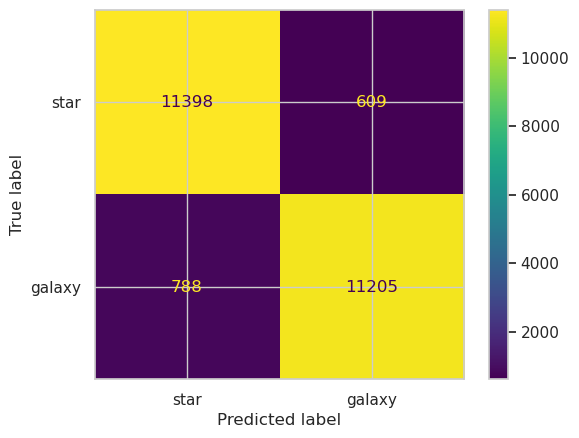

Accuracy on train set of the model LogisticRegression: 0.9418
Precision on train set of the model LogisticRegression: 0.9485
Recall on train set of the model LogisticRegression: 0.9343
F1 on train set of the model LogisticRegression: 0.9413
AUC on train set of the model LogisticRegression: 0.9418

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12007
           1       0.95      0.93      0.94     11993

    accuracy                           0.94     24000
   macro avg       0.94      0.94      0.94     24000
weighted avg       0.94      0.94      0.94     24000



In [16]:
result = evaluate_model(lr, on="train", plot_cmat=True, verbose=True)

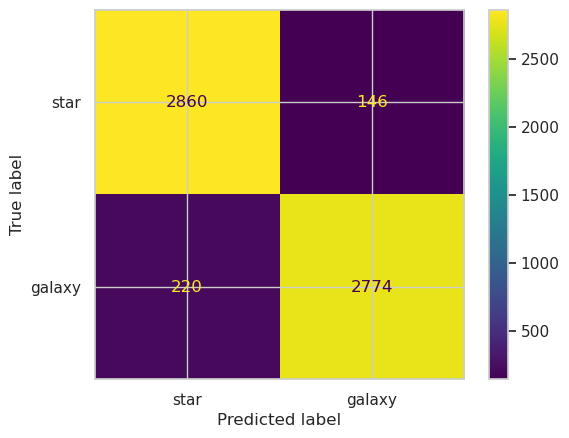

Accuracy on test set of the model LogisticRegression: 0.9390
Precision on test set of the model LogisticRegression: 0.9500
Recall on test set of the model LogisticRegression: 0.9265
F1 on test set of the model LogisticRegression: 0.9381
AUC on test set of the model LogisticRegression: 0.9390

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3006
           1       0.95      0.93      0.94      2994

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [17]:
result = evaluate_model(lr, on="test", plot_cmat=True, verbose=True)

In [18]:
evaluate_and_save_progress(lr, "Logistic Regression")

Model Logistic Regression already exists in the file train_results.csv.
Model Logistic Regression already exists in the file test_results.csv.


## SVC

In [19]:
svc_base = SVC()
svc_base.fit(X_train, y_train)

SVC()

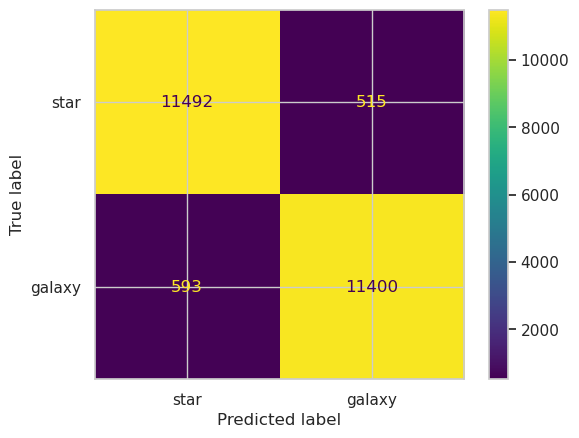

Accuracy on train set of the model SVC: 0.9538
Precision on train set of the model SVC: 0.9568
Recall on train set of the model SVC: 0.9506
F1 on train set of the model SVC: 0.9537
AUC on train set of the model SVC: 0.9538

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12007
           1       0.96      0.95      0.95     11993

    accuracy                           0.95     24000
   macro avg       0.95      0.95      0.95     24000
weighted avg       0.95      0.95      0.95     24000



In [20]:
result = evaluate_model(svc_base, on="train", plot_cmat=True, verbose=True)

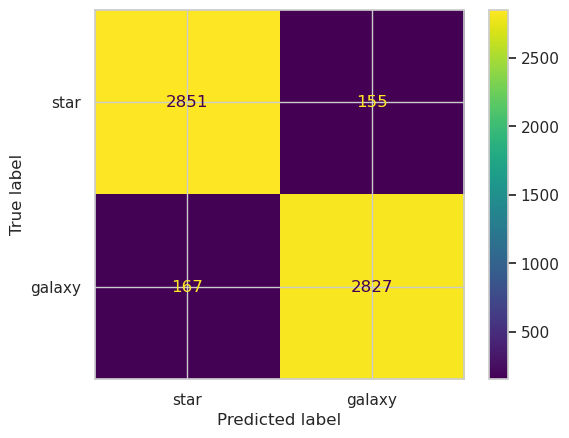

Accuracy on test set of the model SVC: 0.9463
Precision on test set of the model SVC: 0.9480
Recall on test set of the model SVC: 0.9442
F1 on test set of the model SVC: 0.9461
AUC on test set of the model SVC: 0.9463

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3006
           1       0.95      0.94      0.95      2994

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [21]:
result = evaluate_model(svc_base, on="test", plot_cmat=True, verbose=True)

In [22]:
evaluate_and_save_progress(svc_base, "SVC Base")

Model SVC Base already exists in the file train_results.csv.
Model SVC Base already exists in the file test_results.csv.


## SVC Fine Tuning

In [23]:
# create a grid search using optuna
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-5, 1e5)
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
    kernel = trial.suggest_categorical("kernel", ["rbf", "sigmoid"])
    degree = trial.suggest_int("degree", 1, 10)
    coef0 = trial.suggest_loguniform("coef0", 1e-5, 1e5)

    model = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [24]:
# # create a study object
# study = optuna.create_study(direction="maximize", study_name="SVC", )
# # optimize the objective function
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [25]:
def create_text_message(study):
    """
    This function creates a text message from the study object.

    Parameters
    ----------
    study : optuna study object
        The study object.

    Returns
    -------
    message : str
        The message to be sent.
    """
    message = f"Study Name: {study.study_name}\n"
    message += f"Number of trials: {len(study.trials)}\n"
    message += "Here are the best parameters:\n"
    message += "-----------------------------\n"
    best_params = study.best_params
    for key, value in best_params.items():
        message += f"{key} : {value}\n"
    best_value = study.best_value
    message += f"Best Accuracy: {best_value:.4f}"
    return message

In [26]:
# message = create_text_message(study)
# print(message)

SVC Best parameters:
```python
{'C': 16296.601892646648,
 'gamma': 0.0011879874407358082,
 'kernel': 'rbf',
 'degree': 2,
 'coef0': 61.32196047340159}
 ```

In [27]:
svc_best = {'C': 16296.601892646648,
 'gamma': 0.0011879874407358082,
 'kernel': 'rbf',
 'degree': 2,
 'coef0': 61.32196047340159}

In [28]:
svc_base = SVC(**svc_best)
svc_base.fit(X_train, y_train)

SVC(C=16296.601892646648, coef0=61.32196047340159, degree=2,
    gamma=0.0011879874407358082)

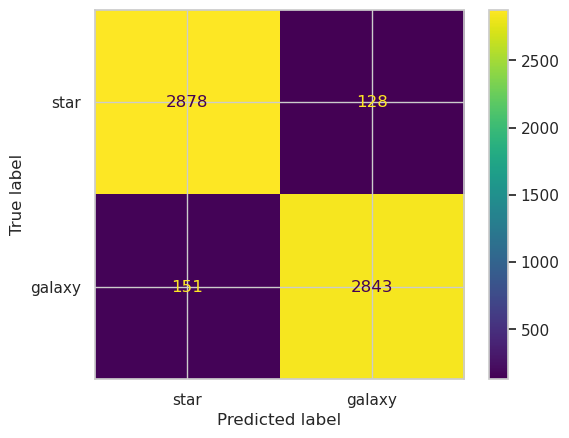

Accuracy on test set of the model SVC: 0.9535
Precision on test set of the model SVC: 0.9569
Recall on test set of the model SVC: 0.9496
F1 on test set of the model SVC: 0.9532
AUC on test set of the model SVC: 0.9535

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3006
           1       0.96      0.95      0.95      2994

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [29]:
result = evaluate_model(svc_base, on="test", plot_cmat=True, verbose=True)

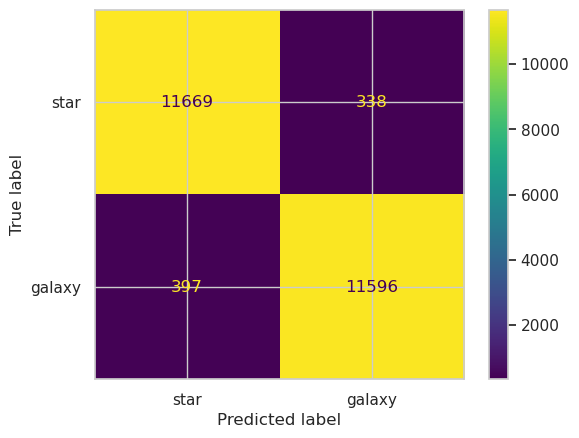

Accuracy on train set of the model SVC: 0.9694
Precision on train set of the model SVC: 0.9717
Recall on train set of the model SVC: 0.9669
F1 on train set of the model SVC: 0.9693
AUC on train set of the model SVC: 0.9694

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12007
           1       0.97      0.97      0.97     11993

    accuracy                           0.97     24000
   macro avg       0.97      0.97      0.97     24000
weighted avg       0.97      0.97      0.97     24000



In [30]:
result = evaluate_model(svc_base, on="train", plot_cmat=True, verbose=True)

In [31]:
evaluate_and_save_progress(svc_base, "SVC Final")

## Random Forest

In [32]:
def objective(trial):
    #Create an objective for random forest classifier
    n_estimators = trial.suggest_int("n_estimators", 2, 200)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])
    max_samples = trial.suggest_categorical("max_samples", [0.5, 0.7, 0.9, 1.0])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=max_samples,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [33]:
# # create a study object
# study = optuna.create_study(direction="maximize", study_name="Random Forest")
# # optimize the objective function
# study.optimize(objective, n_trials=100, show_progress_bar=True)

In [34]:
# message = create_text_message(study)
# print(message)

Random Forest Best Parameters
```python
{'n_estimators': 76,
 'max_depth': 19,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_samples': 1.0}
```

In [35]:
best_params = {'n_estimators': 76,
 'max_depth': 19,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_samples': 1.0}

In [36]:
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, max_features='sqrt', max_samples=1.0,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=76)

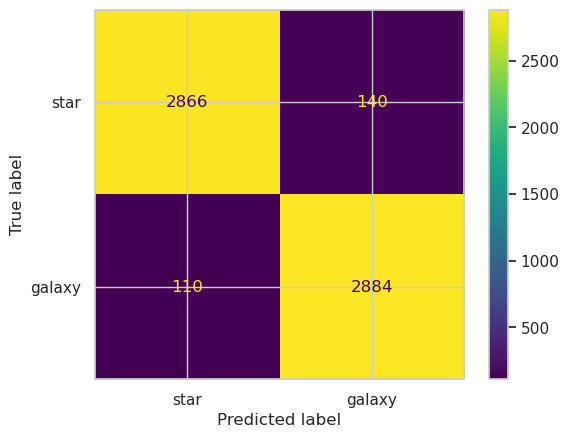

Accuracy on test set of the model RandomForestClassifier: 0.9583
Precision on test set of the model RandomForestClassifier: 0.9537
Recall on test set of the model RandomForestClassifier: 0.9633
F1 on test set of the model RandomForestClassifier: 0.9585
AUC on test set of the model RandomForestClassifier: 0.9583

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3006
           1       0.95      0.96      0.96      2994

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



In [37]:
result = evaluate_model(rfc, on="test", plot_cmat=True, verbose=True)

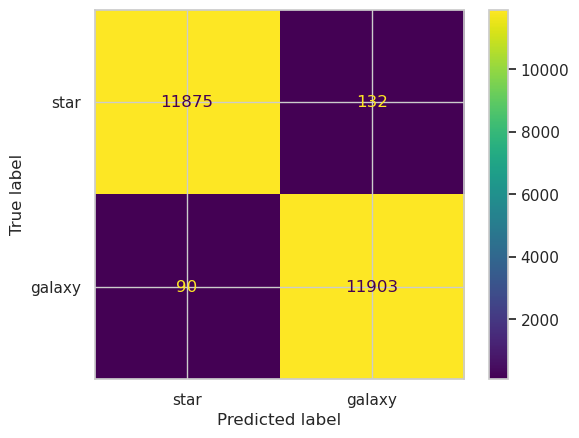

Accuracy on train set of the model RandomForestClassifier: 0.9908
Precision on train set of the model RandomForestClassifier: 0.9890
Recall on train set of the model RandomForestClassifier: 0.9925
F1 on train set of the model RandomForestClassifier: 0.9908
AUC on train set of the model RandomForestClassifier: 0.9908

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12007
           1       0.99      0.99      0.99     11993

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



In [38]:
result = evaluate_model(rfc, on="train", plot_cmat=True, verbose=True)

In [39]:
evaluate_and_save_progress(rfc, "Random Forest Final")

## XGBoost

In [40]:
#Create a study for xgboost
def objective(trial):
    #Create an objective for xgboost classifier
    n_estimators = trial.suggest_int("n_estimators", 2, 200)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    subsample = trial.suggest_categorical("subsample", [0.5, 0.7, 0.9, 1.0])
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-5, 1e5)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-5, 1e5)
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 20)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        min_child_weight=min_child_weight,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

# create a study object
# study = optuna.create_study(direction="maximize", study_name="XGBoost")
# optimize the objective function
# study.optimize(objective, n_trials=100, show_progress_bar=True)

In [41]:
# message = create_text_message(study)
# print(message)

XGBoost Best Parameters
```python
{'n_estimators': 188,
 'max_depth': 17,
 'learning_rate': 0.08245844777734937,
 'subsample': 0.9,
 'reg_alpha': 0.16634334643800422,
 'reg_lambda': 0.010449329514317554,
 'gamma': 3.5712964675328855e-05,
 'min_child_weight': 17}
```

In [42]:
best_params = {'n_estimators': 188,
 'max_depth': 17,
 'learning_rate': 0.08245844777734937,
 'subsample': 0.9,
 'reg_alpha': 0.16634334643800422,
 'reg_lambda': 0.010449329514317554,
 'gamma': 3.5712964675328855e-05,
 'min_child_weight': 17}

xgbc = XGBClassifier(**best_params)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3.5712964675328855e-05, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.08245844777734937,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=17,
              max_leaves=0, min_child_weight=17, missing=nan,
              monotone_constraints='()', n_estimators=188, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.16634334643800422, reg_lambda=0.010449329514317554, ...)

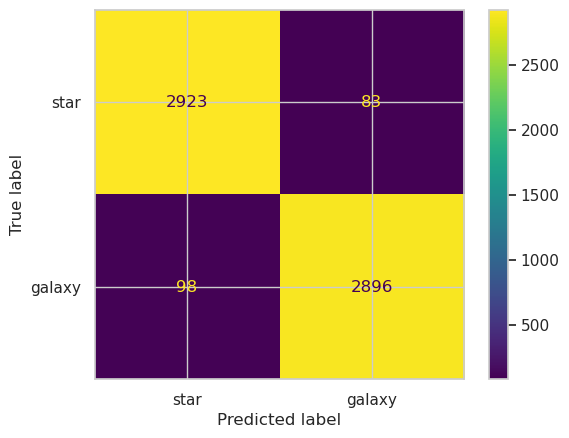

Accuracy on test set of the model XGBClassifier: 0.9698
Precision on test set of the model XGBClassifier: 0.9721
Recall on test set of the model XGBClassifier: 0.9673
F1 on test set of the model XGBClassifier: 0.9697
AUC on test set of the model XGBClassifier: 0.9698

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3006
           1       0.97      0.97      0.97      2994

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



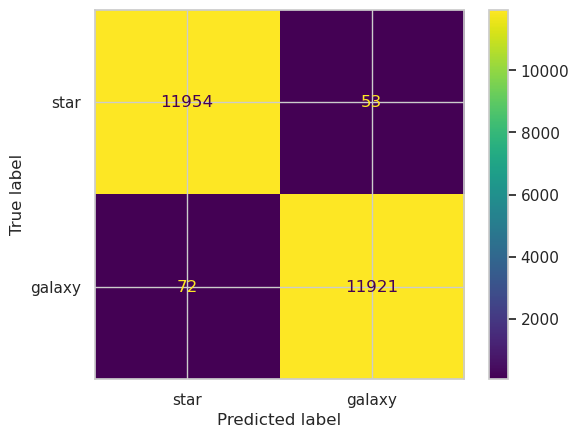

Accuracy on train set of the model XGBClassifier: 0.9948
Precision on train set of the model XGBClassifier: 0.9956
Recall on train set of the model XGBClassifier: 0.9940
F1 on train set of the model XGBClassifier: 0.9948
AUC on train set of the model XGBClassifier: 0.9948

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12007
           1       1.00      0.99      0.99     11993

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



In [43]:
result = evaluate_model(xgbc, on="test", plot_cmat=True, verbose=True)
result = evaluate_model(xgbc, on="train", plot_cmat=True, verbose=True)

In [44]:
evaluate_and_save_progress(xgbc, "XGBoost Final")

## Catboost

In [45]:
#create a study for catboost
def objective(trial):
    #Create an objective for catboost classifier
    n_estimators = trial.suggest_int("n_estimators", 100, 200)
    max_depth = trial.suggest_int("max_depth", 4, 10, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    subsample = trial.suggest_categorical("subsample", [0.8, 0.9, 1.0])
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 1, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 1, 10)
    max_bin = trial.suggest_int("max_bin", 100, 255)

    model = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_lambda=reg_lambda,
        min_child_samples=min_child_samples,
        max_bin=max_bin,
        verbose=0,
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

# create a study object
# study = optuna.create_study(direction="maximize", study_name="CatBoost")
# # optimize the objective function
# study.optimize(objective, n_trials=100, show_progress_bar=True)

In [46]:
# message = create_text_message(study)
# print(message)

Catboost Best Parameters:
```python
{'n_estimators': 198,
 'max_depth': 10,
 'learning_rate': 0.009814179840225703,
 'subsample': 0.8,
 'reg_lambda': 0.7960086364994374,
 'min_child_samples': 3,
 'max_bin': 255}
```

In [47]:
# study.best_params

In [48]:
best_params = {'n_estimators': 198,
 'max_depth': 10,
 'learning_rate': 0.009814179840225703,
 'subsample': 0.8,
 'reg_lambda': 0.7960086364994374,
 'min_child_samples': 3,
 'max_bin': 255}

In [49]:
cbc = CatBoostClassifier(**best_params)
cbc.fit(X_train, y_train, verbose = False)

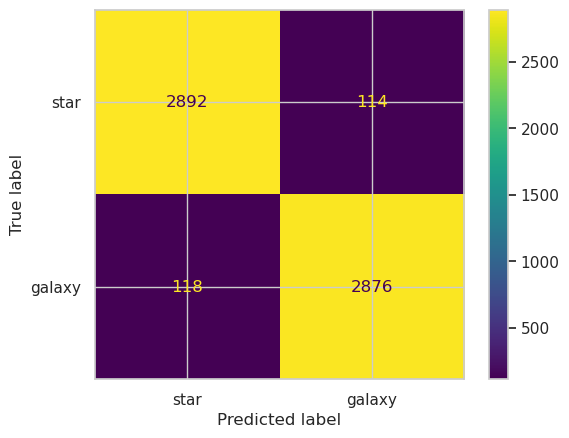

Accuracy on test set of the model CatBoostClassifier: 0.9613
Precision on test set of the model CatBoostClassifier: 0.9619
Recall on test set of the model CatBoostClassifier: 0.9606
F1 on test set of the model CatBoostClassifier: 0.9612
AUC on test set of the model CatBoostClassifier: 0.9613

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3006
           1       0.96      0.96      0.96      2994

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



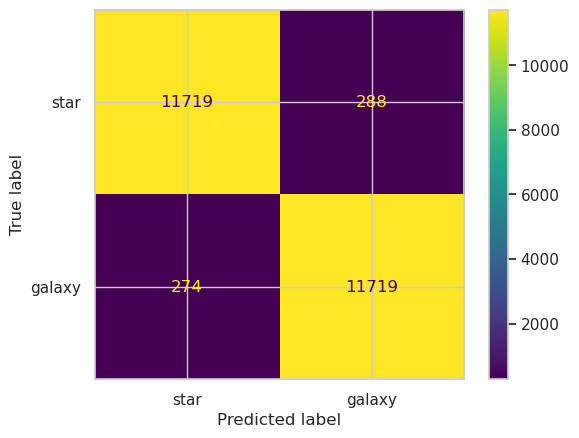

Accuracy on train set of the model CatBoostClassifier: 0.9766
Precision on train set of the model CatBoostClassifier: 0.9760
Recall on train set of the model CatBoostClassifier: 0.9772
F1 on train set of the model CatBoostClassifier: 0.9766
AUC on train set of the model CatBoostClassifier: 0.9766

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12007
           1       0.98      0.98      0.98     11993

    accuracy                           0.98     24000
   macro avg       0.98      0.98      0.98     24000
weighted avg       0.98      0.98      0.98     24000



In [50]:
result = evaluate_model(cbc, on="test", plot_cmat=True, verbose=True)
result = evaluate_model(cbc, on="train", plot_cmat=True, verbose=True)

In [51]:
evaluate_and_save_progress(cbc, "Catboost Final")